In [16]:
## IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, mean_absolute_percentage_error, r2_score

In [17]:
## DUMMIES

def check_for_dummies(columns):
    dummies_collumns = []
    for column in ['Gallery', 'Artist']:
        if column in columns:
            dummies_collumns.append(column)
    return len(dummies_collumns)

def get_dummies(train, test, dummies_collumns):
    train_dummies = pd.get_dummies(train, columns=dummies_collumns)
    test_dummies = pd.get_dummies(test, columns=dummies_collumns)
    # add missing columns to test set
    missing_cols = set(train_dummies.columns) - set(test_dummies.columns)
    missing_cols_list = list(missing_cols)
    missing_cols_df = pd.DataFrame(0, columns=missing_cols_list, index=test_dummies.index)
    test_dummies = pd.concat([test_dummies, missing_cols_df], axis=1)

    return train_dummies, test_dummies

In [18]:
## MODELS

def get_decision_tree(X_train, y_train):
    decision_tree = DecisionTreeRegressor(random_state=42)
    decision_tree.fit(X_train, y_train)
    return decision_tree

def get_linear_regression(X_train, y_train):
    linear_regression = LinearRegression()
    linear_regression.fit(X_train, y_train)
    return linear_regression

def get_random_forest(X_train, y_train):
    rf_model = RandomForestRegressor(random_state=1)
    rf_model.fit(X_train, y_train)
    return rf_model

def get_gradient_boosting(X_train, y_train):
    # get gradient boosting model
    gb_model = GradientBoostingRegressor(random_state=1)
    gb_model.fit(X_train, y_train)
    return gb_model

# gives a dataframe taking models as columns and score as rows
def get_all_models(x_train, x_test, y_train, y_test):
    
    models = {'Linear regression': get_linear_regression(x_train, y_train),
              'Decision tree': get_decision_tree(x_train, y_train),
              'Random forest': get_random_forest(x_train, y_train),
              'Gradient boosting': get_gradient_boosting(x_train, y_train)}
    
    models_df = pd.DataFrame(columns=models.keys())
    for model_name, model in models.items():
        y_pred = model.predict(x_test)
        r2 = r2_score(y_test, y_pred)
        n = len(y_test)
        p = x_test.shape[1]
        adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        mean_error = mean_absolute_error(y_test, y_pred)
        median_error = median_absolute_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        pearson = np.corrcoef(y_test.astype(float), y_pred)[0, 1]

        models_df.loc['R² Score', model_name] = r2
        models_df.loc['Adjusted R² Score', model_name] = adj_r2
        models_df.loc['Pearson Correl Predicted-Actual', model_name] = pearson
        models_df.loc['Mean Absolute Error', model_name] = mean_error
        models_df.loc['Median Absolute Error', model_name] = median_error
        models_df.loc['Mean Squared Error', model_name] = mse

        # Round values
        models_df = models_df.round(2)

    return models_df, models

In [19]:
## FILTERS

MATERIALS_OPTIONS = [
    "acrílico", "aquarela", "óleo", "papel", "pastel",
    "pintura", "tela", "aquarela", "nanquim",
    "policromia", "resina", "tinta acrílica", "tinta a óleo",
    "sobre tela", "sobre papel", "sobre madeira", "serigrafia", 
    "litografia", "litogravura", "gravura"
    ]

In [31]:
## GETTING DATA

# Read in the data
artrio = pd.read_csv('../temporary-files/artrio_artworks_info.csv')
artsoul = pd.read_csv('../temporary-files/artsoul_artworks_info.csv')
sparte = pd.read_csv('../temporary-files/sparte_artworks_info.csv')
sparte.rename(columns={'Size': 'Area'}, inplace=True)
nano = pd.read_csv('../temporary-files/nano_artworks_info.csv')
nano.rename(columns={'Galeria': 'Gallery'}, inplace=True)

In [21]:
## KEEP ONLY PAINTINGS

# ARTRIO
artrio = artrio.dropna(subset='Ficha técnica')
# ficha técnica column to lowercase
artrio['Ficha técnica'] = artrio['Ficha técnica'].str.lower()
artrio = artrio[artrio['Ficha técnica'].str.contains('|'.join(MATERIALS_OPTIONS))]

# ARTSOUL
artsoul = artsoul.dropna(subset=['Description', 'Técnicas'])
artsoul['Description'] = artsoul['Description'].str.lower()
artsoul['Técnicas'] = artsoul['Técnicas'].str.lower()
artsoul = artsoul[artsoul['Description'].str.contains('|'.join(MATERIALS_OPTIONS)) | artsoul['Técnicas'].str.contains('|'.join(MATERIALS_OPTIONS))]

# NANO
nano = nano.dropna(subset=['Categories'])
nano['Categories'] = nano['Categories'].str.lower()
nano = nano[nano['Categories'].str.contains('|'.join(MATERIALS_OPTIONS))]

# SPARTE
sparte = sparte.dropna(subset=['Description'])
sparte['Description'] = sparte['Description'].str.lower()
sparte = sparte[sparte['Description'].str.contains('|'.join(MATERIALS_OPTIONS))]

In [ ]:
## AGGREGATE MARKETPLACES DATA
df = pd.concat([artrio, artsoul, sparte, nano], ignore_index=True)

In [36]:
# from df, get artworks with substring 'Chagall' in 'Artist' column
chagall = df[df['Artist'].str.contains('Marc')]
chagall

,Artist,Title,Price,Sobre a obra,Ficha técnica,Sobre o artista,ARTE HALL,MOVIMENTO,Galeria Athena,Arte FASAM Galeria,...,Size,Price / cm²,Marketplace,GalleryLink,ArtistLink,Categories,Título,URL,Valor,Técnica
92,Marcia Thompson,"sem título, 2020",3000.0,NaN,"objeto, tinta óleo, renda, gesso e linho. ed. ...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,Marcela Gontijo,Mutação 1,4000.0,A série I CHING de Marcela Gontijo é inspirada...,acrílica sobre tela,NaN,NaN,"Sob direção de Ricardo Kimaid Jr, a Galeria Mo...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144,Marcos Chaves,Stoned,4000.0,NaN,2014 | impressão fine art com pigmento mineral...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145,Marcelo Pallotta,Sem Título,4000.0,"Sem título, da série Polanturas",2017 30cm x 40cm polaroid e aquarela sobre papel,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
171,Marcos Chaves,Sem título,4500.0,NaN,serigrafia | 2002 | 70x100 cm | ed. 50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189,Marcos da Matta,Botijão dourado,5000.0,NaN,"acrílica sobre tela, 60x50cm, 2021 chassi",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218,Marcos da Matta,Bom dia!,5500.0,NaN,"acrílica sobre tela, 60x60cm, 2022 obra em chassi",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263,Marcelo Mello,"Bardo e Rapsodo, 2022",7000.0,NaN,acrílica sobre tela,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
271,Marcos da Matta,Com qualquer 2 mil réis,7500.0,NaN,"acrílica sobre tela, 100x70cm, 2022",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
291,Marcela Gontijo,Mutação 1,8200.0,I CHING A série I CHING de Marcela Gontijo é i...,acrílica sobre tela,NaN,NaN,"Sob direção de Ricardo Kimaid Jr, a Galeria Mo...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
## GETTING GALLERIES DATAFRAME

galleries_df = df[['Gallery', 'Area', 'Price', 'Artist']]
galleries_df.loc[:,'Gallery'] = galleries_df['Gallery'].str.upper()

In [23]:
## CLEANING GALLERY COLUMN

substrings = ['GALERIA DE ARTE', 'GALLERY', 'ESCRITÓRIO DE ARTE', 'ARTE CONTEMPORÂNEA', 'ARTE', 'GALERIA', '-']
for substring in substrings:
    galleries_df.loc[:,'Gallery'] = galleries_df['Gallery'].str.replace(substring, '')
galleries_df.loc[:,'Gallery'] = galleries_df['Gallery'].str.strip()

print(len(galleries_df['Gallery'].unique()), ' galleries found')
galleries_df['Gallery'].unique()

148  galleries found


array(['MOVIMENTO', 'HALL', 'ATHENA', 'FASAM', 'MARTHA PAGY',
       'EDITORA COBOGÓ', 'MUL.TI.PLO ESPAÇO', 'LONA', 'CASSIA BOMENY',
       'PORTAS VILASECA', 'RV CULTURA E', 'MERCEDES VIEGAS', 'CENTRAL',
       'NARA ROESLER', 'JANAINA TORRES', 'C.', 'MATIAS BROTAS',
       'CARCARA PHOTO ART', 'GABY INDIO DA COSTA', 'AURA', 'OMA',
       'MARCIA BARROZO DO AMARAL', 'FÓLIO', 'ESTAÇÃO', 'CARBONO',
       'SILVIA CINTRA + BOX 4', 'LUCIANA BRITO', 'ANITA SCHWARTZ',
       'SIMÕES DE ASSIS', 'SUPERFÍCIE', 'MARIO COHEN', 'GUSTAVO REBELLO',
       'MILLAN', 'ZAGUT', 'GRAVURA BRASILEIRA', 'ZILDA FRALETTI',
       'YBAKATU', 'ROBERTA BOTTCHER', 'DE  MAMUTE', 'SALA',
       'TINA ZAPPOLI', 'CHARLES CENCI', 'ANETE RING', 'ABACT',
       'VERÔNICA ALKMIM FRANÇA', 'JORGE ISMAEL', 'MARIO BAPTISTA',
       'TARCISO DE LIMA', 'GABRIEL NEHEMY', 'RAFAEL ADORJÁN', 'SA PASSOS',
       'NACIONAL TROVOA', 'VALERIA KHOURI', 'RITA MANHÃES',
       'MYRIAM GLATT', 'BRUNO LYRA STUDIO', 'ANA MARIA FARINA',
   

In [24]:
max_quantil, min_quantil = 0.95, 0.05 ## QUANTILES TO REMOVE OUTLIERS

galleries_df.loc[:,'Price/Area'] = galleries_df.loc[:,'Price'] / galleries_df.loc[:,'Area']
galleries_df = galleries_df[galleries_df['Price/Area'] < galleries_df['Price/Area'].quantile(max_quantil)]
galleries_df = galleries_df[galleries_df['Price/Area'] > galleries_df['Price/Area'].quantile(min_quantil)]
galleries_df.drop(columns=['Price/Area'], inplace=True)

galleries_df.shape

/var/folders/rt/d94hn0nj1cl2kykjjkdpswxw0000gn/T/ipykernel_22490/3417369011.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  galleries_df.loc[:,'Price/Area'] = galleries_df.loc[:,'Price'] / galleries_df.loc[:,'Area']


(796, 4)

In [25]:
log = False ## LOG SWITCH

if log:
    area = np.log(galleries_df['Area'].astype(float))
    price = np.log(galleries_df['Price'].astype(float))
else:
    area = galleries_df['Area']
    price = galleries_df['Price']

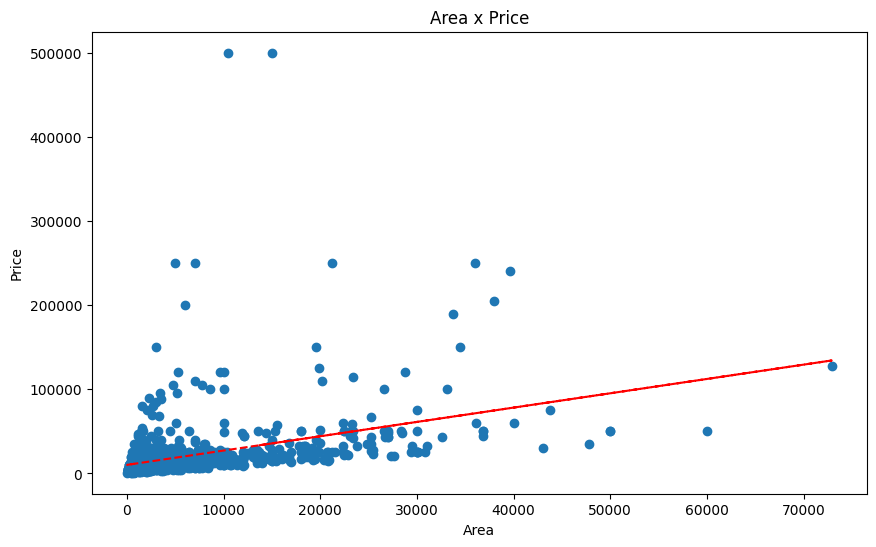

In [26]:
## AREA X PRICE

galleries_df = galleries_df.dropna()

area = pd.to_numeric(area, errors='coerce')
price = pd.to_numeric(price, errors='coerce')

# plot area x price
plt.figure(figsize=(10, 6))
plt.scatter(area, price)
plt.xlabel('Area')
plt.ylabel('Price')
plt.title('Area x Price')
# include trend line
z = np.polyfit(area, price, 1)
p = np.poly1d(z)
plt.plot(area, p(area),"r--")

plt.show()


In [27]:
columns = ['Area', 'Gallery', 'Artist', 'Price'] ## APPLYING MODELS

galleries_df_to_model = galleries_df[columns].dropna()

# train test split
train, test = train_test_split(galleries_df_to_model, test_size=0.25, random_state=123)

dummies_columns = ['Gallery', 'Artist']

if check_for_dummies(columns):
    train, test = get_dummies(train, test, dummies_columns)

x_train = train.drop('Price', axis=1)
y_train = train['Price']
x_test = test.drop('Price', axis=1)
y_test = test['Price']

# adjust columns
x_test = x_test[x_train.columns]

models_df, models = get_all_models(x_train, x_test, y_train, y_test)

models_df

,Linear regression,Decision tree,Random forest,Gradient boosting
R² Score,0.276237,0.294155,0.28232,0.248486
Adjusted R² Score,1.709431,1.691868,1.703468,1.736632
Pearson Correl Predicted-Actual,0.547812,0.577849,0.580622,0.509683
Mean Absolute Error,11400.775286,9067.19598,9556.430529,11740.529796
Median Absolute Error,3999.183825,2000.0,2712.0,5802.312507
Mean Squared Error,690909149.978775,673804114.090452,685101915.206549,717399726.596019


In [28]:
len(x_train.columns)

400

In [29]:
# save model in a pickle file
import pickle
pickle.dump(models['Random forest'], open('./models/rf_br_marketplaces.pkl', 'wb'))

# save test df as csv
x_test.to_csv('./models/x_br_marketplaces.csv', index=False)

galleries = galleries_df['Gallery'].unique()
artists = galleries_df['Artist'].unique()

# save galleries and artists as csv
pd.DataFrame(galleries).to_csv('./models/galleries_br_marketplaces.csv', index=False)
pd.DataFrame(artists).to_csv('./models/artists_br_marketplaces.csv', index=False)

In [30]:
## PLOT PREDICTED PRICE X ACTUAL PRICE

model = models['Gradient boosting']

prediction = model.predict(x_test)

if log:
    prediction = np.log(prediction)

# add gb_prediction to galleries_df dataframes
x_test['Predicted Price'] = prediction
x_test.sort_values(by='Price', ascending=False)

# plot price x prediction with same scale on x and y axes
plt.figure(figsize=(6, 6))
plt.scatter(y_test, prediction)
plt.xlabel('Price')
plt.ylabel('Prediction')
plt.title('Price x Prediction')
# include trend line
z = np.polyfit(y_test.astype(float), prediction, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test),"r--")

plt.show()

KeyError: 'Price'

In [ ]:
feature_importances_df = pd.DataFrame(model.feature_importances_,
                                      index = x_test.columns,
                                        columns=['Feature Importance']).sort_values('Feature Importance', ascending=False)

feature_importances_df.head(20)

# list of features with importance greater than 0.001
features_to_keep = feature_importances_df[feature_importances_df['Feature Importance'] > 0.001].index.tolist()

feature_filtered_df = galleries_df[features_to_keep]

# train test split
train, test = train_test_split(feature_filtered_df, test_size=0.25, random_state=123)

if check_for_dummies(columns):
    train, test = get_dummies(train, test, dummies_collumns)

x_train = train.drop('Price', axis=1)
y_train = train['Price']
x_test = test.drop('Price', axis=1)
y_test = test['Price']

# adjust columns
x_test = x_test[x_train.columns]

models_df, models = get_all_models(x_train, x_test, y_train, y_test)

models_df


ValueError: Shape of passed values is (392, 1), indices imply (27, 1)

In [ ]:
galleries_df[:-2]['Gallery'].value_counts()

Gallery
FASAM                               90
MERCEDES VIEGAS                     49
JANAINA TORRES                      49
MARTHA PAGY                         46
MUL.TI.PLO ESPAÇO                   36
                                    ..
DESAPÊ                               1
57 – RENATO MAGALHAES GOUVÊA JR.     1
ARTUR FIDALGO                        1
JACQUELINE TERPINS                   1
CELMA ALBUQUERQUE                    1
Name: count, Length: 78, dtype: int64

In [ ]:
# dataframe with gallery mean price and mean price per area columns
galleries_mean = galleries_df.groupby('Gallery').mean()
# add count column


galleries_mean.rename(columns={'Price': 'Mean price', 'Area': 'Mean price/area'}, inplace=True)
galleries_mean['Mean price'] = pd.to_numeric(galleries_mean['Mean price'], errors='coerce')
galleries_mean.sort_values(by='Mean price', ascending=False, inplace=True)
galleries_mean.round(0)


TypeError: Could not convert Raymundo Colares to numeric